In [1]:
from collections import deque
from graphviz import Digraph

NUM_MISSIONARIES = 3
NUM_CANNIBALS = 3
BOAT_CAPACITY = 2

In [2]:
class State:
    def __init__(self, num_missionaries: int, num_cannibals: int, boat: bool) -> None:
        self.state = (num_missionaries, num_cannibals, boat)

    def __repr__(self) -> str:
        return str(self.state)

    @staticmethod
    def initial_state() -> 'State':
        """Return the starting state."""
        return State(NUM_MISSIONARIES, NUM_CANNIBALS, True)

    def is_final(self) -> bool:
        """Check if we have reached the goal state."""
        return self.state == (0, 0, False)

    def is_valid(self) -> bool:
        """Check if a state is valid.

        A state is invalid if:
        - Numbers are out of bounds
        - Missionaries are outnumbered by cannibals on either side (when missionaries > 0)

        Returns:
            True if state is valid, False otherwise
        """
        num_missionaries, num_cannibals = self.state[0], self.state[1]

        # Check bounds
        if not (
            (0 <= num_missionaries <= NUM_MISSIONARIES)
            and (0 <= num_cannibals <= NUM_CANNIBALS)
        ):
            return False

        # Check missionaries aren't outnumbered on starting side
        if not ((num_missionaries == 0) or (num_missionaries >= num_cannibals)):
            return False

        # Calculate other side
        num_missionaries_other_side = NUM_MISSIONARIES - num_missionaries
        num_cannibals_other_side = NUM_CANNIBALS - num_cannibals

        # Check missionaries aren't outnumbered on the other side
        if not (
            (num_missionaries_other_side == 0)
            or (num_missionaries_other_side >= num_cannibals_other_side)
        ):
            return False

        return True

    def apply_action(self, action: tuple[int, int]) -> 'State':
        """Apply an action to a state to get a new state.

        Args:
            action: Action to apply

        Returns:
            New state after applying the action
        """
        return State(
            self.state[0] + action[0], self.state[1] + action[1], not self.state[2]
        )

    def expand(self) -> list[tuple[tuple[int, int], 'State']]:
        """Return all valid successor states from the current state.

        Returns:
            List of (action, successor_state) pairs
        """
        direction = -1 if self.state[2] else 1  # -1 if boat present, +1 otherwise

        # Generate all the possible actions
        actions = [
            (direction * m, direction * c)
            for m in range(NUM_MISSIONARIES)  # 0-2 missionaries
            for c in range(NUM_CANNIBALS)  # 0-2 cannibals
            if 0 < m + c <= BOAT_CAPACITY  # boat capacity constraint
            and (
                direction == -1
                and m <= self.state[0]
                and c <= self.state[1]
                or direction == 1
                and m <= NUM_MISSIONARIES - self.state[0]
                and c <= NUM_CANNIBALS - self.state[1]
            )
        ]

        # Generate all the resulting states from these actions
        valid_states = [(a, self.apply_action(a)) for a in actions]

        # Return only the valid states
        return [(a, s) for a, s in valid_states if s.is_valid()]

    def __eq__(self, other) -> bool:
        """Overrides the default implementation"""
        if isinstance(other, State):
            return self.state == other.state
        return False

    def __hash__(self) -> int:
        """Overrides the default implementation"""
        return int(f'{self.state[0]}{self.state[1]}{1 if self.state[2] else 0}')

In [3]:
class Node:
    """Represents a node in the search tree.

    Attributes:
        id: A counter to keep track of the number of nodes generated
        state: The state for this node
        parent: Parent node (None for root)
        action: Action taken to reach this node
        path_cost: Cost of path from root to this node
    """

    id: int = 0

    def __init__(self, state: State, parent: 'Node | None' = None, action: tuple[int, int] | None = None, path_cost: int = 0, id: int | None = None) -> None:  # fmt: skip
        if id is not None:
            Node.id = id
        self.id: int = Node.id
        Node.id += 1

        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost

    def __repr__(self) -> str:
        parent_id = -1 if self.parent is None else str(self.parent.id)
        return (
            f'{self.id=}, {self.action=}, {parent_id=}, {self.path_cost=}, {self.state}'
        )

    def expand_node(self) -> list['Node']:
        """Generate all children for this node.

        Returns:
            List of nodes
        """
        children = []
        for action, state in self.state.expand():
            children.append(
                Node(state, parent=self, action=action, path_cost=self.path_cost + 1)
            )
        return children

    def get_path(self) -> list[tuple[tuple[int, int], State]]:
        """Reconstruct the path from root to this node.

        Returns:
            List of (action, state) pairs from root to current node
        """
        path = []
        node = self
        while node is not None:
            path.append((node.action, node.state))
            node = node.parent
        return list(reversed(path))

In [4]:
def bfs_naive(initial_state: State) -> Node | None:
    root_node = Node(state=initial_state, id=0)
    frontier = deque([root_node])

    if root_node.state.is_final():
        return root_node

    while len(frontier) > 0:
        node = frontier.popleft()

        for child in node.expand_node():
            if child.state.is_final():
                return child
            else:
                frontier.append(child)

    return None


def bfs_set(initial_state: State) -> Node | None:
    root_node = Node(state=initial_state, id=0)
    frontier = deque([root_node])
    reached = set([initial_state])

    if root_node.state.is_final():
        return root_node

    while len(frontier) > 0:
        node = frontier.popleft()

        for child in node.expand_node():
            if child.state.is_final():
                return child
            elif child.state not in reached:
                frontier.append(child)
                reached.add(child.state)

    return None

In [5]:
root = State.initial_state()

In [6]:
res = bfs_naive(root)
print(res)
res.get_path()

self.id=10963, self.action=(0, -2), parent_id='4800', self.path_cost=11, (0, 0, False)


[(None, (3, 3, True)),
 ((0, -2), (3, 1, False)),
 ((0, 1), (3, 2, True)),
 ((0, -2), (3, 0, False)),
 ((0, 1), (3, 1, True)),
 ((-2, 0), (1, 1, False)),
 ((1, 1), (2, 2, True)),
 ((-2, 0), (0, 2, False)),
 ((0, 1), (0, 3, True)),
 ((0, -2), (0, 1, False)),
 ((0, 1), (0, 2, True)),
 ((0, -2), (0, 0, False))]

In [7]:
bfs_set(root)

self.id=28, self.action=(0, -2), parent_id='24', self.path_cost=11, (0, 0, False)

In [8]:
%timeit bfs_naive(root)
%timeit bfs_set(root)

40.3 ms ± 2.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
145 μs ± 8.8 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
# Generate graphviz visualization of a solution
def generate_viz(node: Node) -> Digraph:
    dot = Digraph('tree_solution')
    dot.graph_attr['rankdir'] = 'TB'

    parent = node.parent
    while parent is not None:
        dot.node(str(node.id), label=str(node.state))
        dot.edge(f'{parent.id}', f'{node.id}', label=f'{node.action}')

        node = parent
        parent = node.parent
    dot.node(str(node.id), label=str(node.state))

    return dot

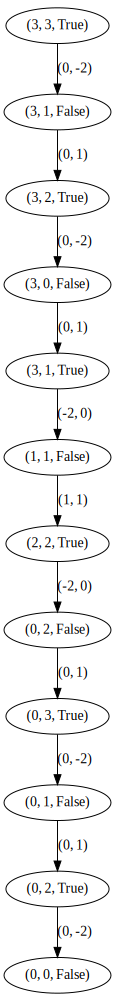

In [ ]:
res = bfs_set(root)
tree_solution = generate_viz(res)

tree_solution.render(directory='dot-output', format='pdf').replace('\\', '/')
tree_solution

In [11]:
def bfs_graphviz(initial_state: State) -> Digraph:
    dot = Digraph('graph_space')
    dot.graph_attr['rankdir'] = 'TB'

    root_node = Node(state=initial_state, id=0)
    frontier = deque([root_node])
    reached = set([initial_state])

    while len(frontier) > 0:
        node = frontier.popleft()
        dot.node(
            str(hash(node.state)),
            label=str(node.state),
            penwidth=('3' if node.state.is_final() else '1'),
        )

        list_nodes_same_rank = []
        for child in node.expand_node():
            if child.state not in reached:
                frontier.append(child)
                reached.add(child.state)

                list_nodes_same_rank.append(str(hash(child.state)))

            dot.edge(
                f'{hash(node.state)}', f'{hash(child.state)}', label=f'{child.action}'
            )

        # We keep track of nodes on the same level of the graph, and use rank='same' option to tidy the graph
        if len(list_nodes_same_rank) > 1:
            with dot.subgraph() as s:
                s.attr(rank='same')
                for node_same_rank in list_nodes_same_rank:
                    s.node(node_same_rank)

    return dot

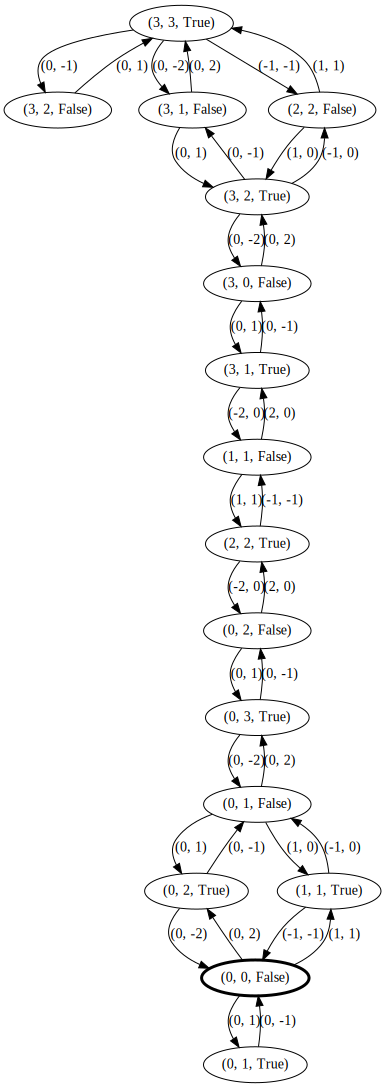

In [ ]:
graph_space = bfs_graphviz(root)

graph_space.render(directory='dot-output', format='pdf').replace('\\', '/')
graph_space